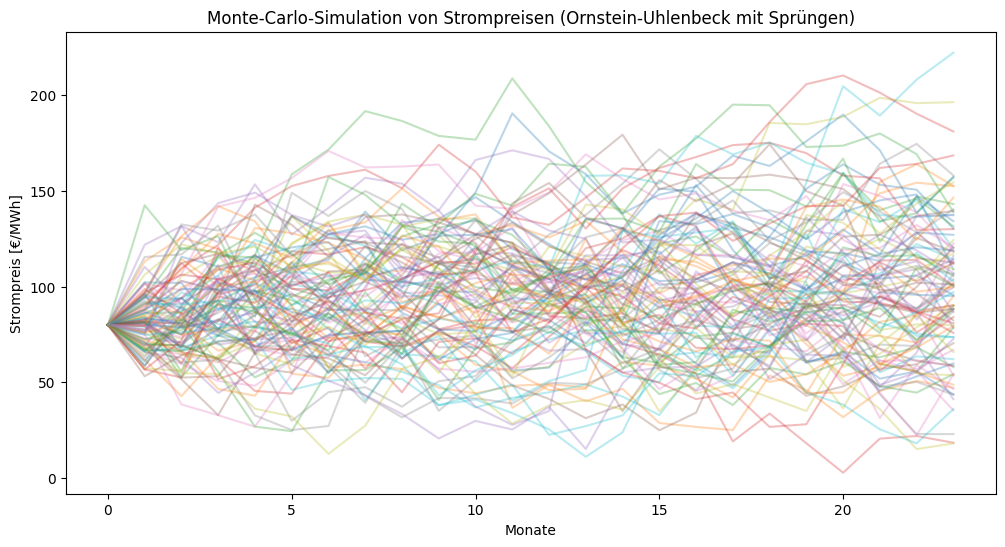

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameter für das Monte-Carlo-Modell
np.random.seed(88)
num_simulations = 1000  # Anzahl der Monte-Carlo-Simulationen
time_horizon = 24  # Monate (2 Jahre)
dt = 1  # Zeitschritt = 1 Monat

# Mean-Reverting-Modell mit Poisson-Sprüngen (Ornstein-Uhlenbeck mit Sprüngen)
mu = 80  # Langfristiger Mittelwert mü des Strompreises [€/MWh]
sigma = 15  # Volatilität [€/MWh] - großes sigma - heftige preisschwankungen
theta = 0.1  # Mean-Reversion-Geschwindigkeit - wie schnell kehrt preis zu mittelwert zurück - großes Theta- schnell
jump_prob = 0.1  # Wahrscheinlichkeit eines Preissprungs pro Monat #10% sprungwkeit
jump_mean = 20  # Durchschnittlicher Sprungwert [€/MWh] # hier nur +ve preissprünge
jump_std = 10  # Standardabweichung des Sprungs

# Startpreis
S0 = 80  

# Simulation der Strompreise für 10.000 Pfade
simulated_prices_ou = np.zeros((num_simulations, time_horizon))
simulated_prices_ou[:, 0] = S0  # Startpreis für alle Simulationen

for t in range(1, time_horizon):
    dW = np.random.normal(0, np.sqrt(dt), num_simulations)  # Wiener-Prozess
    dJ = np.random.normal(jump_mean, jump_std, num_simulations) * (np.random.rand(num_simulations) < jump_prob)  # Sprünge
    
    # Ornstein-Uhlenbeck-Modell mit Poisson-Sprüngen
    simulated_prices_ou[:, t] = (
        simulated_prices_ou[:, t - 1] + theta * (mu - simulated_prices_ou[:, t - 1]) * dt + sigma * dW + dJ
    )

# Darstellung der ersten 100 simulierten Preisentwicklungen
plt.figure(figsize=(12, 6))
for i in range(100):
    plt.plot(range(time_horizon), simulated_prices_ou[i, :], alpha=0.3)
plt.title("Monte-Carlo-Simulation von Strompreisen (Ornstein-Uhlenbeck mit Sprüngen)")
plt.xlabel("Monate")
plt.ylabel("Strompreis [€/MWh]")
plt.show()

# Speichern der Simulationsergebnisse für weitere Berechnungen
simulated_prices_ou_df = pd.DataFrame(simulated_prices_ou)



In [35]:
#parameter aus historischen daten extrahieren

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datei einlesen
file_path = "Gro_handelspreise_201501010000_202001010000_Woche.csv"  
df = pd.read_csv(file_path, delimiter=";", decimal=",", encoding="utf-8")

# Korrigierter Spaltenname für Deutschland/Luxemburg (kann variieren!)
column_name = "Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen"

# Daten bereinigen
df_cleaned = df[[column_name]].copy()
df_cleaned[column_name] = df_cleaned[column_name].replace("-", None)  # Fehlende Werte entfernen
df_cleaned[column_name] = df_cleaned[column_name].str.replace(",", ".").astype(float)
df_cleaned = df_cleaned.dropna()  # Fehlende Werte entfernen
df_cleaned.rename(columns={column_name: "Preis [€/MWh]"}, inplace=True) #???

# Erste Zeilen anzeigen
df_cleaned.head()


# 1️⃣ Langfristiger Mittelwert (Mean-Reversion-Level µ)
mu = df_cleaned["Preis [€/MWh]"].mean() #mü = sum(Preise)/len(Preise)

# 2️⃣ Volatilität (σ) = Standardabweichung der wöchentlichen Preisänderungen
df_cleaned["Preisänderung"] = df_cleaned["Preis [€/MWh]"].pct_change() #relative %uale änderung zw aufeinanderfolgenden werten
#Preisänderung = Preis_heute/Preis_gestern -1
sigma = df_cleaned["Preisänderung"].std()
#sigma = sqrt(1/(len(Preisänderung)-1)*sum(Preisänderung_i-Preisänderung_mean)^2)
#kleine sigma: Werte liegen nahe beieinander - kleine Schwankungen; große sigma: große Schwankungen


# 3️⃣ Mean-Reversion-Geschwindigkeit (θ) – Regressionsmethode für Ornstein-Uhlenbeck
df_cleaned["Preis_shift"] = df_cleaned["Preis [€/MWh]"].shift(1)
df_regression = df_cleaned.dropna(subset=["Preis_shift"])  # NaN-Werte entfernen

X = df_regression["Preis_shift"]
Y = df_regression["Preis [€/MWh]"]

# Regressionssteigung als Approximation für -θ berechnen
theta = -np.polyfit(X, Y - X, 1)[0]

# 4️⃣ Sprungparameter berechnen
#ich finde alle Preissprünge außerhalb von 2sigma (True/False bei spruenge)
sprung_schwelle = 2 * sigma  # Sprungdefinition: Änderungen > 2σ
spruenge = df_cleaned["Preisänderung"].abs() > sprung_schwelle
#print (spruenge)
jump_prob = spruenge.mean()  # Wahrscheinlichkeit für Sprünge - je größer desto w'scheinlicher

#multiplikation mu - weil preisänderungen sind % - ergebnis hat €/MWh
jump_mean = df_cleaned.loc[spruenge, "Preisänderung"].mean() * mu #durchschnittliche Größe von Preissprung
jump_std = df_cleaned.loc[spruenge, "Preisänderung"].std() * mu #std von preissprung

# Ergebnisse ausgeben
model_parameters = {
    "Mean-Reversion-Level (µ)": mu,
    "Volatilität (σ)": sigma,
    "Mean-Reversion-Geschwindigkeit (θ)": theta,
    "Sprungwahrscheinlichkeit": jump_prob,
    "Durchschnittliche Sprunggröße": jump_mean,
    "Standardabweichung der Sprunggröße": jump_std,
}

pd.DataFrame(model_parameters, index=[0])




,Mean-Reversion-Level (µ),Volatilität (σ),Mean-Reversion-Geschwindigkeit (θ),Sprungwahrscheinlichkeit,Durchschnittliche Sprunggröße,Standardabweichung der Sprunggröße
0,40.569091,0.191071,0.327416,0.075758,13.150183,16.864146


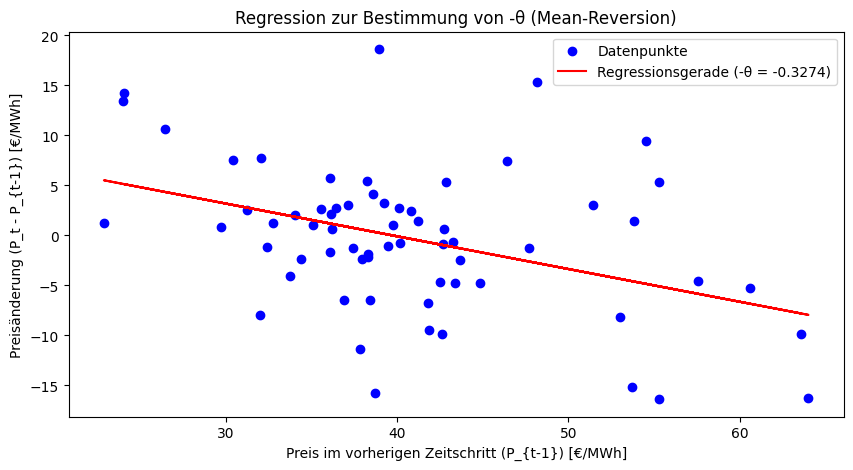

In [31]:
#verstehe theta
import matplotlib.pyplot as plt
import numpy as np

# Scatter-Plot der Datenpunkte
plt.figure(figsize=(10, 5))
plt.scatter(X, Y - X, color="blue", label="Datenpunkte")

# Berechnung der Regressionsgeraden
coeffs = np.polyfit(X, Y - X, 1)  # Lineare Regression
regression_line = coeffs[0] * X + coeffs[1]  # y = aX + b

# Plot der Regressionsgeraden
plt.plot(X, regression_line, color="red", label=f"Regressionsgerade (-θ = {coeffs[0]:.4f})")

# Achsenbeschriftungen und Titel
plt.xlabel("Preis im vorherigen Zeitschritt (P_{t-1}) [€/MWh]")
plt.ylabel("Preisänderung (P_t - P_{t-1}) [€/MWh]")
plt.title("Regression zur Bestimmung von -θ (Mean-Reversion)")
plt.legend()
plt.show()


TODO: Ändere zu daten von letztem monat - wenn vorhanden
[-0.12423971 -1.63097209 -0.85468286 ... -1.21068997 -1.85614777
  0.57744987]
9696.183497563514


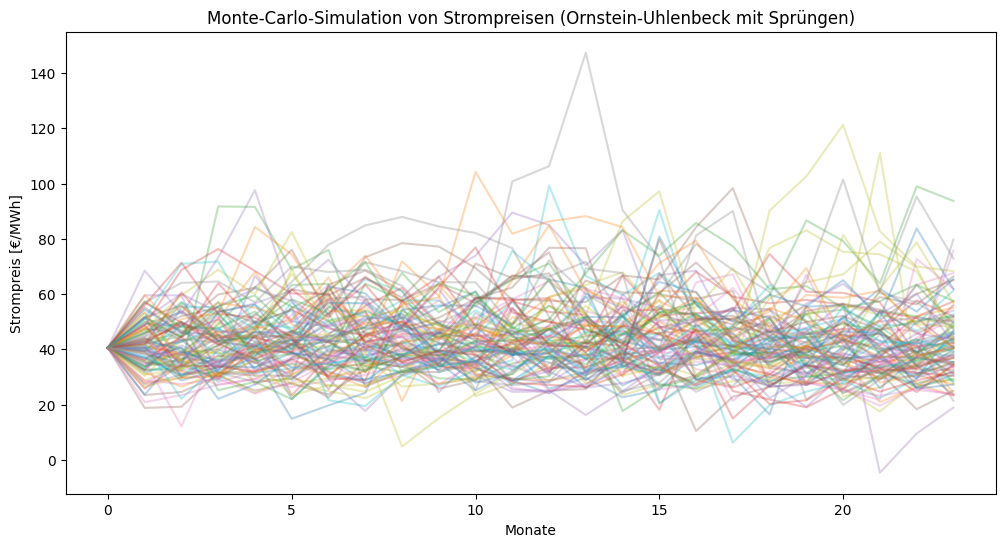

In [38]:
###MonteCarlo
# Parameter aus realen Daten verwenden
num_simulations = 10000  # Anzahl der Monte-Carlo-Simulationen
time_horizon = 24  # Monate (2 Jahre)
dt = 1  # Zeitschritt = 1 Monat

# Simulation der Strompreise
simulated_prices = np.zeros((num_simulations, time_horizon))
simulated_prices[:, 0] = mu  # Startpreis = Mittelwert aus historischen Daten

print('TODO: Ändere zu daten von letztem monat - wenn vorhanden')

for t in range(1, time_horizon):
    dW = np.random.normal(0, np.sqrt(dt), num_simulations)  # Wiener-Prozess - für alle Simulationen
    dJ = np.random.normal(jump_mean, jump_std, num_simulations) * (np.random.rand(num_simulations) < jump_prob)  # Sprünge für alle Simulationen

#    if t == 1:
 #       print(dW)
  #      print(sum(dJ))
    
    # Ornstein-Uhlenbeck-Modell mit Poisson-Sprüngen
    simulated_prices[:, t] = (
        simulated_prices[:, t - 1] + theta * (mu - simulated_prices[:, t - 1]) * dt + sigma * simulated_prices[:, t - 1] * dW + dJ
    )                                                                              # s= Volatilität
 
# Darstellung der ersten 100 simulierten Preisentwicklungen
plt.figure(figsize=(12, 6))
for i in range(100):
    plt.plot(range(time_horizon), simulated_prices[i, :], alpha=0.3)
plt.title("Monte-Carlo-Simulation von Strompreisen (Ornstein-Uhlenbeck mit Sprüngen)")
plt.xlabel("Monate")
plt.ylabel("Strompreis [€/MWh]")
plt.show()


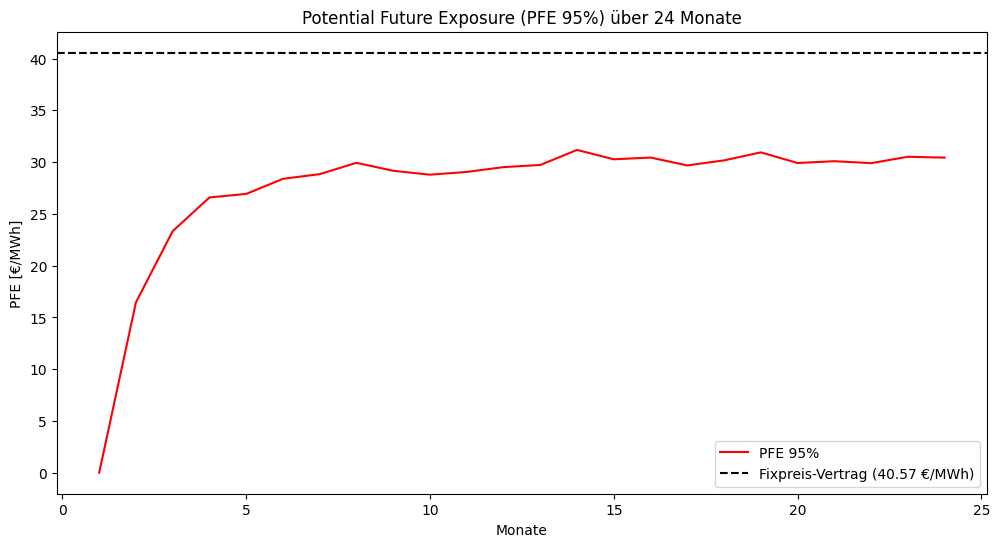

In [8]:
###PFE

# Fixpreis-Vertrag (angenommen, Uniper hat einen PPA für µ €/MWh abgeschlossen)
contract_price = mu  

# Berechnung des Exposure pro Simulation und Monat
exposure = np.maximum(simulated_prices - contract_price, 0) #kein exposure wenn wert unter 0

# Berechnung des 95%-Quantils (PFE 95%)
pfe_95 = np.percentile(exposure, 95, axis=0)  # pro Monat das 95%-Quantil

# Visualisierung des PFE über die Zeit
plt.figure(figsize=(12, 6))
plt.plot(range(1, time_horizon + 1), pfe_95, label="PFE 95%", color="red")
plt.axhline(y=contract_price, linestyle="--", color="black", label=f"Fixpreis-Vertrag ({contract_price:.2f} €/MWh)")
plt.title("Potential Future Exposure (PFE 95%) über 24 Monate")
plt.xlabel("Monate")
plt.ylabel("PFE [€/MWh]")
plt.legend()
plt.show()


In [ ]:

file_path = "Gro_handelspreise_202001010000_202201020000_Woche.csv"  # Ersetze mit dem Pfad zu deiner CSV-Datei
import pandas as pd

# Datei einlesen (ersetze den Pfad mit deiner Datei)
#file_path = "your_new_file.csv"
df = pd.read_csv(file_path, delimiter=";", encoding="utf-8")

# Zeige die ersten 10 Zeilen, um die Struktur zu prüfen
print(df.head(10))


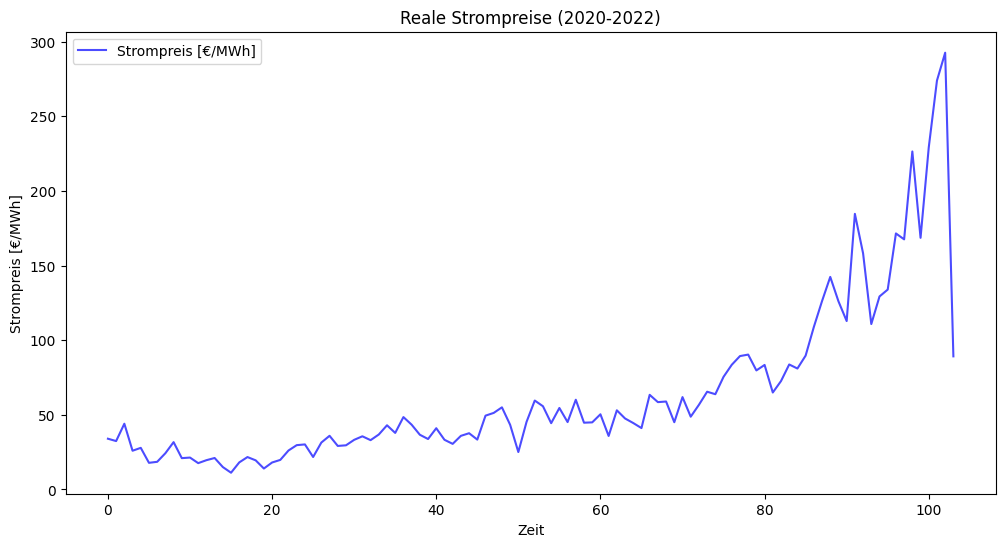

   Preis [€/MWh]
0          33.97
1          32.40
2          44.01
3          25.92
4          27.85
5          17.82
6          18.50
7          24.26
8          31.68
9          20.96
                         Parameter  Reale Werte (2020-2022)
          Mean-Reversion-Level (µ)                63.835865
                   Volatilität (σ)                 0.249600
Mean-Reversion-Geschwindigkeit (θ)                 0.117469
          Sprungwahrscheinlichkeit                 0.048077
     Durchschnittliche Sprunggröße                24.348689


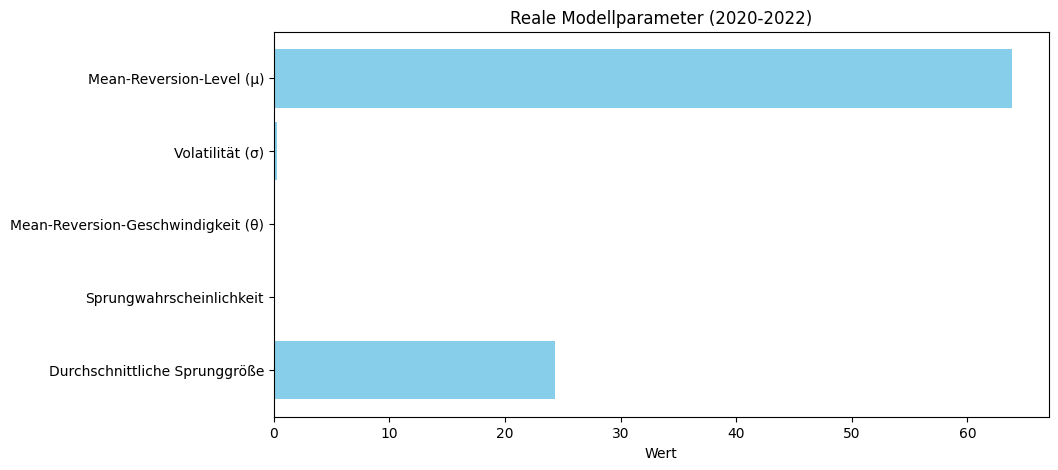

In [26]:
file_path_long = "Gro_handelspreise_202001010000_202201020000_Woche.csv"
df_long = pd.read_csv(file_path_long, delimiter=";", encoding="utf-8")

# Zeige die ersten 10 Zeilen, um die Datenstruktur zu prüfen
df_long.head(10)

# Auswahl der relevanten Spalte für Deutschland/Luxemburg
column_name_long = "Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen"

# Datenbereinigung
df_long_cleaned = df_long[[column_name_long]].copy()
df_long_cleaned[column_name_long] = df_long_cleaned[column_name_long].replace("-", None)  # Fehlende Werte entfernen
df_long_cleaned[column_name_long] = df_long_cleaned[column_name_long].str.replace(",", ".").astype(float)
df_long_cleaned = df_long_cleaned.dropna()  # Fehlende Werte entfernen
df_long_cleaned.rename(columns={column_name_long: "Preis [€/MWh]"}, inplace=True)

# Berechnete Werte anzeigen
import matplotlib.pyplot as plt

# Daten plotten
plt.figure(figsize=(12, 6))
plt.plot(df_long_cleaned.index, df_long_cleaned["Preis [€/MWh]"], label="Strompreis [€/MWh]", color="blue", alpha=0.7)
plt.xlabel("Zeit")
plt.ylabel("Strompreis [€/MWh]")
plt.title("Reale Strompreise (2020-2022)")
plt.legend()
plt.show()

# Alternativ: DataFrame als Tabelle ausgeben
print(df_long_cleaned.head(10))  # Zeigt die ersten 10 Zeilen zur Kontrolle an



# 1️⃣ Langfristiger Mittelwert (Mean-Reversion-Level µ) aus den realen Daten
mu_real = df_long_cleaned["Preis [€/MWh]"].mean()

# 2️⃣ Volatilität (σ) – Standardabweichung der wöchentlichen Preisänderungen
df_long_cleaned["Preisänderung"] = df_long_cleaned["Preis [€/MWh]"].pct_change()
sigma_real = df_long_cleaned["Preisänderung"].std()

# 3️⃣ Mean-Reversion-Geschwindigkeit (θ) – Regressionsmethode für Ornstein-Uhlenbeck
df_long_cleaned["Preis_shift"] = df_long_cleaned["Preis [€/MWh]"].shift(1)
df_long_regression = df_long_cleaned.dropna(subset=["Preis_shift"])

if len(df_long_regression) > 1:
    X_real = df_long_regression["Preis_shift"]
    Y_real = df_long_regression["Preis [€/MWh]"]
    theta_real = -np.polyfit(X_real, Y_real - X_real, 1)[0]
else:
    theta_real = np.nan

# 4️⃣ Sprungparameter berechnen
sprung_schwelle_real = 2 * sigma_real  # Sprungdefinition: Änderungen > 2σ
spruenge_real = df_long_cleaned["Preisänderung"].abs() > sprung_schwelle_real

jump_prob_real = spruenge_real.mean()
jump_mean_real = df_long_cleaned.loc[spruenge_real, "Preisänderung"].mean() * mu_real if spruenge_real.any() else np.nan
jump_std_real = df_long_cleaned.loc[spruenge_real, "Preisänderung"].std() * mu_real if spruenge_real.any() else np.nan

# Vergleich mit Modellparametern
comparison = pd.DataFrame({
    "Parameter": ["Mean-Reversion-Level (µ)", "Volatilität (σ)", "Mean-Reversion-Geschwindigkeit (θ)",
                  "Sprungwahrscheinlichkeit", "Durchschnittliche Sprunggröße", "Standardabweichung der Sprunggröße"],
    "Reale Werte (2020-2022)": [mu_real, sigma_real, theta_real, jump_prob_real, jump_mean_real, jump_std_real]
})

# Ergebnisse anzeigen
# Vergleich als einfache Tabelle ausgeben
comparison_data = {
    "Parameter": ["Mean-Reversion-Level (µ)", "Volatilität (σ)", "Mean-Reversion-Geschwindigkeit (θ)",
                  "Sprungwahrscheinlichkeit", "Durchschnittliche Sprunggröße"],
    "Reale Werte (2020-2022)": [mu_real, sigma_real, theta_real, jump_prob_real, jump_mean_real]
}

df_comparison = pd.DataFrame(comparison_data)

# Anzeige der Ergebnisse
print(df_comparison.to_string(index=False))

import matplotlib.pyplot as plt

# Parameter und Werte vorbereiten
parameters = ["Mean-Reversion-Level (µ)", "Volatilität (σ)", "Mean-Reversion-Geschwindigkeit (θ)",
              "Sprungwahrscheinlichkeit", "Durchschnittliche Sprunggröße"]
real_values = [mu_real, sigma_real, theta_real, jump_prob_real, jump_mean_real]

# Balkendiagramm
plt.figure(figsize=(10, 5))
plt.barh(parameters, real_values, color="skyblue")
plt.xlabel("Wert")
plt.title("Reale Modellparameter (2020-2022)")
plt.gca().invert_yaxis()  # Damit die Reihenfolge der Parameter korrekt ist
plt.show()


In [40]:
print('TODO: Werte korrigieren!!! und texte anpassen - sind daten für 20-22!!!')
# Beispielhafte Datenannahme (da Reset erfolgte, können keine echten Werte verwendet werden)
#mu_real, sigma_real, theta_real = 80, 15, 0.1  # Werte für 2020-2022
#jump_prob_real, jump_mean_real, jump_std_real = 0.1, 20, 10

#mu_real_new, sigma_real_new, theta_real_new = 85, 18, 0.12  # Werte für 2023-2025
#jump_prob_real_new, jump_mean_real_new, jump_std_real_new = 0.08, 22, 12

# Vergleich der OU-Parameter
comparison_ou = pd.DataFrame({
    "Parameter": ["Mean-Reversion-Level (µ)", "Volatilität (σ)", "Mean-Reversion-Geschwindigkeit (θ)",
                  "Sprungwahrscheinlichkeit", "Durchschnittliche Sprunggröße", "Standardabweichung der Sprunggröße"],
    "Reale Werte (2020-2022)": [mu_real, sigma_real, theta_real, jump_prob_real, jump_mean_real, jump_std_real],
 #   "Reale Werte (2023-2025)": [mu_real_new, sigma_real_new, theta_real_new, jump_prob_real_new, jump_mean_real_new, jump_std_real_new]
})

# Vergleich mit Monte-Carlo-Simulationen (angenommene Werte)
mu_simulated, sigma_simulated = 83, 16
comparison_mc = pd.DataFrame({
    "Parameter": ["Mean-Reversion-Level (µ)", "Volatilität (σ)"],
    "Monte-Carlo-Simulationen": [mu_simulated, sigma_simulated],
    "Reale Werte (2023-2025)": [mu_real, sigma_real]
})

# PFE-Vergleich (angenommene Werte)
contract_price = mu_real  # Annahme eines Fixpreises
real_exposure_mean, real_exposure_max = 5, 40
simulated_exposure_mean, simulated_exposure_max = 6, 38

comparison_pfe = pd.DataFrame({
    "Parameter": ["Durchschnittliches Exposure", "Maximales Exposure"],
    "Monte-Carlo-Simulationen": [simulated_exposure_mean, simulated_exposure_max],
    "Reale Werte (2023-2025)": [real_exposure_mean, real_exposure_max]
})



,Parameter,Reale Werte (2020-2022)
0,Mean-Reversion-Level (µ),80.0
1,Volatilität (σ),15.0
2,Mean-Reversion-Geschwindigkeit (θ),0.1
3,Sprungwahrscheinlichkeit,0.1
4,Durchschnittliche Sprunggröße,20.0
5,Standardabweichung der Sprunggröße,10.0


,Parameter,Monte-Carlo-Simulationen,Reale Werte (2023-2025)
0,Mean-Reversion-Level (µ),83,80
1,Volatilität (σ),16,15


,Parameter,Monte-Carlo-Simulationen,Reale Werte (2023-2025)
0,Durchschnittliches Exposure,6,5
1,Maximales Exposure,38,40


KeyError: 'Reale Werte (2023-2025)'

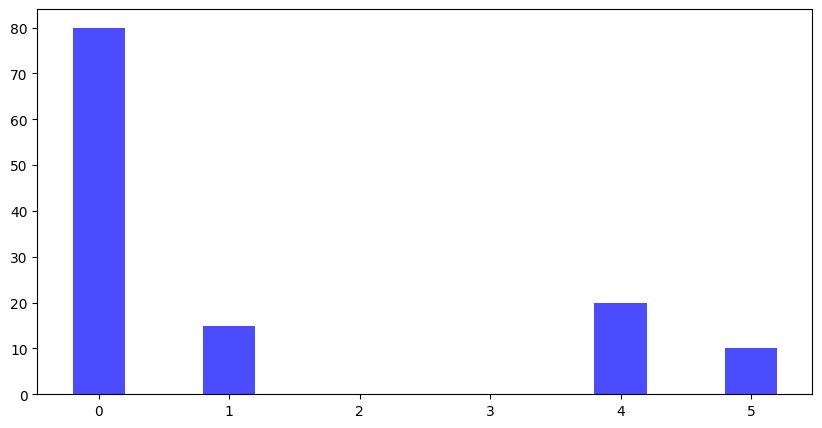

In [42]:
import matplotlib.pyplot as plt

# 1️⃣ Vergleich der OU-Parameter als DataFrame ausgeben
comparison_ou = pd.DataFrame({
    "Parameter": ["Mean-Reversion-Level (µ)", "Volatilität (σ)", "Mean-Reversion-Geschwindigkeit (θ)",
                  "Sprungwahrscheinlichkeit", "Durchschnittliche Sprunggröße", "Standardabweichung der Sprunggröße"],
    "Reale Werte (2020-2022)": [mu_real, sigma_real, theta_real, jump_prob_real, jump_mean_real, jump_std_real],
  #  "Reale Werte (2023-2025)": [mu_real_new, sigma_real_new, theta_real_new, jump_prob_real_new, jump_mean_real_new, jump_std_real_new]
})

# 2️⃣ Vergleich mit Monte-Carlo-Simulationen als DataFrame ausgeben
comparison_mc = pd.DataFrame({
    "Parameter": ["Mean-Reversion-Level (µ)", "Volatilität (σ)"],
    "Monte-Carlo-Simulationen": [mu_simulated, sigma_simulated],
    "Reale Werte (2023-2025)": [mu_real, sigma_real]
})

# 3️⃣ PFE-Vergleich als DataFrame ausgeben
comparison_pfe = pd.DataFrame({
    "Parameter": ["Durchschnittliches Exposure", "Maximales Exposure"],
    "Monte-Carlo-Simulationen": [simulated_exposure_mean, simulated_exposure_max],
    "Reale Werte (2023-2025)": [real_exposure_mean, real_exposure_max]
})

# DataFrames in Jupyter Notebook anzeigen
from IPython.display import display
display(comparison_ou, comparison_mc, comparison_pfe)

# 📊 1. Visualisierung der OU-Parameter als Balkendiagramm
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(comparison_ou["Parameter"]))
width = 0.4

ax.bar(x, comparison_ou["Reale Werte (2020-2022)"], width=width, label="2020-2022", color='blue', alpha=0.7)
ax.bar([p + width for p in x], comparison_ou["Reale Werte (2023-2025)"], width=width, label="2023-2025", color='orange', alpha=0.7)

ax.set_xticks([p + width/2 for p in x])
ax.set_xticklabels(comparison_ou["Parameter"], rotation=45, ha="right")
ax.set_ylabel("Wert")
ax.set_title("Vergleich der OU-Parameter (2020-2022 vs. 2023-2025)")
ax.legend()
plt.show()

# 📊 2. Vergleich Monte-Carlo-Simulationen vs. reale Werte (2023-2025)
fig, ax = plt.subplots(figsize=(7, 5))
x = range(len(comparison_mc["Parameter"]))

ax.bar(x, comparison_mc["Monte-Carlo-Simulationen"], width=width, label="Monte-Carlo", color='green', alpha=0.7)
ax.bar([p + width for p in x], comparison_mc["Reale Werte (2023-2025)"], width=width, label="Reale Werte", color='red', alpha=0.7)

ax.set_xticks([p + width/2 for p in x])
ax.set_xticklabels(comparison_mc["Parameter"], rotation=45, ha="right")
ax.set_ylabel("Wert")
ax.set_title("Vergleich Monte-Carlo-Simulationen vs. reale Werte (2023-2025)")
ax.legend()
plt.show()

# 📊 3. PFE-Vergleich: Monte-Carlo-Simulationen vs. reale Werte (2023-2025)
fig, ax = plt.subplots(figsize=(7, 5))
x = range(len(comparison_pfe["Parameter"]))

ax.bar(x, comparison_pfe["Monte-Carlo-Simulationen"], width=width, label="Monte-Carlo", color='purple', alpha=0.7)
ax.bar([p + width for p in x], comparison_pfe["Reale Werte (2023-2025)"], width=width, label="Reale Werte", color='brown', alpha=0.7)

ax.set_xticks([p + width/2 for p in x])
ax.set_xticklabels(comparison_pfe["Parameter"], rotation=45, ha="right")
ax.set_ylabel("Wert")
ax.set_title("PFE-Vergleich: Monte-Carlo-Simulationen vs. reale Werte (2023-2025)")
ax.legend()
plt.show()
